# Depth Prediction Example with P2Net

In [1]:
import sys
import os
cwd = os.getcwd()
wd = os.path.join(cwd, "p2net")
sys.path.append(wd)

In [2]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader

from dataset import DepthEstDataset
from networks import ResnetEncoder, DepthDecoder
from layers import disp_to_depth

In [3]:
model_name = "p2net"
# to cap depth between 0.001 and 10
min_depth = 0.001
max_depth = 10

if torch.cuda.is_available:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

### Load model from checkpoint

In [4]:
# checkpoint paths
checkpt_name = "weights_5f"
checkpt_path = os.path.join(model_name, "checkpts", checkpt_name)
encoder_path = os.path.join(checkpt_path, "encoder.pth")
decoder_path = os.path.join(checkpt_path, "depth.pth")
encoder_dict = torch.load(encoder_path, map_location=device)
decoder_dict = torch.load(decoder_path, map_location=device)

In [5]:
encoder = ResnetEncoder(18, False)
decoder = DepthDecoder(num_ch_enc=encoder.num_ch_enc, scales=range(1))
encoder.load_state_dict({k: v for k, v in encoder_dict.items() if k in encoder.state_dict()})
decoder.load_state_dict({k: v for k, v in decoder_dict.items() if k in decoder.state_dict()})
encoder.to(device)
decoder.to(device)
encoder.eval()
decoder.eval()
print("Loaded pretrained depth encoder and decoder")

Loaded pretrained depth encoder and decoder


### Predict depth from input images

In [6]:
depth_dataset = DepthEstDataset(model_name)
test_loader = DataLoader(depth_dataset, batch_size=1, shuffle=True)

In [7]:
with torch.no_grad():
    for batch_id, inputs in enumerate(test_loader):
        # the dataset can be used for both monocular and stereo models
        # only left image is needed for monocular model
        left_im, _, pred_depth_path = inputs
        left_im = left_im.to(device)

        
        features = encoder(left_im)
        outputs = decoder(features)
        disp = outputs[("disp", 0)]  # technically the model outputs inverse depth
        #disp = F.interpolate(disp, (original_height, original_width), mode='bilinear', align_corners=False)
        _, depth = disp_to_depth(disp, min_depth, max_depth)
        depth = depth.detach().cpu().numpy()
        depth = np.squeeze(depth)
        # Note the depth needs to be scaled with median from ground truth prior to computing the error metrics.
        # This is a common practice in unsupervised monocular models since the models have no knowledge of the
        # depth scale
        np.save(pred_depth_path[0], depth)

### Print a sample image and its predicted depth

In [8]:
left_im = torch.squeeze(left_im)
left_im = left_im.detach().cpu()
left_im = transforms.ToPILImage()(left_im)

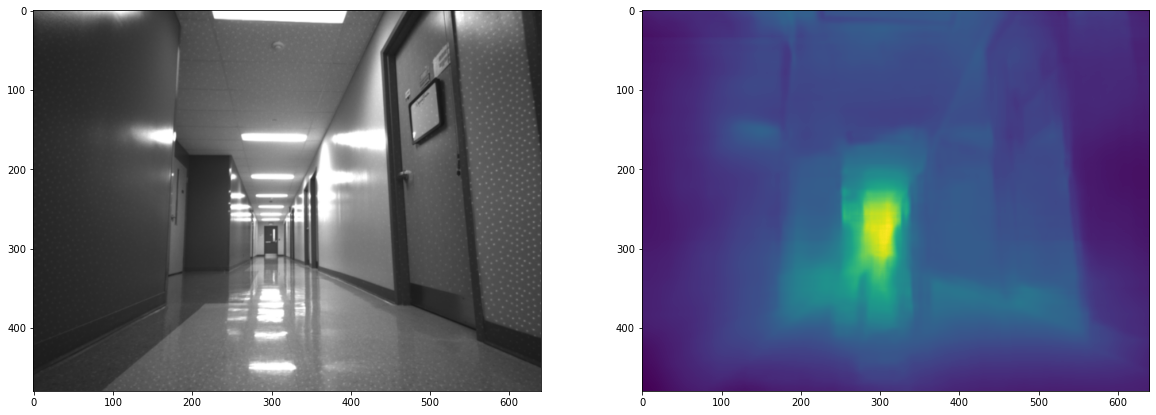

In [9]:
%matplotlib inline
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(left_im)
plt.subplot(122)
plt.imshow(depth)

In [10]:
print(np.amax(depth))  # definitely need to scale depth with median from ground truth
print(np.amin(depth))

0.016866356
0.0041178763
